In [2]:
import warnings
# import time
# import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta, time
from hmmlearn import hmm

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
df_min_month1 = pd.read_csv('./data/extended_intraday_SPY_1min_year1month1_adjusted.csv', parse_dates=['time'])
df_min_month2 = pd.read_csv('./data/extended_intraday_SPY_1min_year1month2_adjusted.csv', parse_dates=['time'])

# print(df_min_month1.shape)
# print(df_min_month2.shape)

df_min = pd.merge(df_min_month1, df_min_month2, how = 'outer')

start_time = pd.to_datetime('9:30').time()
end_time = pd.to_datetime('16:00').time()

df_min = df_min[(df_min['time'].dt.time >= start_time) & (df_min['time'].dt.time <= end_time)]

df_min.head()

,time,open,high,low,close,volume
185,2023-06-01 16:00:00,421.81,421.8300,421.620,421.64,490506
186,2023-06-01 15:59:00,421.44,421.8400,421.440,421.81,2103080
187,2023-06-01 15:58:00,421.45,421.5099,421.360,421.44,820512
188,2023-06-01 15:57:00,421.46,421.5150,421.355,421.44,396704
189,2023-06-01 15:56:00,421.61,421.6400,421.430,421.45,536900


In [5]:
### Some other interval datas: daily, monthly

### open, close, high, low data

### downloaded from 'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol=SPY&apikey=YourAPIKey'
### https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=SPY&outputsize=full&apikey=YourAPIKey
### https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=SPY&interval=1min&slice=year1month2&apikey=Y3H8BI0J9FPQPOAB

# df = pd.read_csv('monthly_adjusted_SPY.csv',  parse_dates=['timestamp'])

# df.rename({'timestamp': 'time'}, axis = 1, inplace= True)

# df.drop(['adjusted close', 'dividend amount'], axis = 1, inplace= True)

# dfhl = pd.read_csv('./daily_adjusted_SPY.csv', parse_dates=['timestamp'])

# dfhl.rename({'timestamp':'time'}, axis = 1, inplace=True)

# df_minutes = pd.read_csv('./algebros0530/dfhl.csv', parse_dates=['time'])


In [6]:
### Other time interval data manipulation

# dfhl.drop(['adjusted_close', 'volume', 'dividend_amount', 'split_coefficient'], axis = 1, inplace= True)

# dfhl

,time,open,high,low,close,volume
185,2023-06-01 16:00:00,421.810,421.8300,421.620,421.6400,490506
186,2023-06-01 15:59:00,421.440,421.8400,421.440,421.8100,2103080
187,2023-06-01 15:58:00,421.450,421.5099,421.360,421.4400,820512
188,2023-06-01 15:57:00,421.460,421.5150,421.355,421.4400,396704
189,2023-06-01 15:56:00,421.610,421.6400,421.430,421.4500,536900
...,...,...,...,...,...,...
34121,2023-04-03 09:34:00,409.340,409.4900,409.335,409.4555,335059
34122,2023-04-03 09:33:00,409.160,409.3850,409.100,409.3200,264486
34123,2023-04-03 09:32:00,409.225,409.2400,409.060,409.1700,194336
34124,2023-04-03 09:31:00,408.940,409.2400,408.930,409.2200,478997


In [62]:
### macd data
### downloaded from 'https://www.alphavantage.co/query?function=MACD&symbol=SPY&interval=monthly&series_type=open&datatype=csv&apikey=Y3H8BI0J9FPQPOAB'

# df_macd = pd.read_csv('technical_indicator_SPY.csv', parse_dates=['time'])

# df_macd

In [63]:
# df_merged = pd.merge(df, df_macd, how = 'inner', on = ['time'])

# # df_merged.sort_values('time', ascending=True, inplace= True)

# df_merged

In [64]:
# data_whole = dfhl.drop(['time'], axis = 1).to_numpy()

# data_whole = df_minutes[['open', 'high', 'low', 'MACD']].to_numpy()

data_whole = df_min[['open', 'high', 'low']].to_numpy()

data_whole

array([[421.81  , 421.83  , 421.62  ],
       [421.44  , 421.84  , 421.44  ],
       [421.45  , 421.5099, 421.36  ],
       ...,
       [409.225 , 409.24  , 409.06  ],
       [408.94  , 409.24  , 408.93  ],
       [408.85  , 409.03  , 408.82  ]])

In [49]:
### Train and test splits
### Avoid 9:30 to 10:30 period, since our program uses previous 120 minutes information to do training
### In 9:30 to 10:30 period, the previous day info will be used



tscv = TimeSeriesSplit(n_splits = 6)

test_idx = []
time_list = []

for i, (train_index, test_index) in enumerate(tscv.split(data_whole)):
    print(test_index[-1])
    test_idx += [test_index[-1]]
    time_list += [df_min.iloc[test_index[-1]]['time']]

time_list = time_list[::-1]

print(time_list, test_idx)

1879
2817
3755
4693
5631
6569
[Timestamp('2023-05-09 10:47:00'), Timestamp('2023-05-11 13:23:00'), Timestamp('2023-05-15 15:59:00'), Timestamp('2023-05-18 12:04:00'), Timestamp('2023-05-22 14:40:00'), Timestamp('2023-05-25 10:45:00')] [1879, 2817, 3755, 4693, 5631, 6569]


In [109]:
num_prediction = 60
num_iteration = 10000
K = 120

MAE_opens, MAE_highs, MAE_lows = [], [], []
comparisions = []

for i in range(len(test_idx)):
    test_index = test_idx[i]
    starting_date = time_list[i]
    
    # Reinitiate data_whole and train_set each time
    data_whole = df_min[['open', 'high', 'low']].to_numpy()
    data_whole = data_whole[test_index:]
    
    predicted_stock_data = np.empty([0,data_whole.shape[1]])
    train_set = data_whole
    
    # The test set is data_whole[range(num_prediction),0]
    

    for idx in reversed(range(num_prediction)):
            train_dataset = train_set[idx + 1:,:]
            test_data = train_set[idx,:]
            num_examples = train_dataset.shape[0]
            
            if idx == NUM_TEST-1:
                model = hmm.GaussianHMM(n_components=4, covariance_type='diag',  tol=0.0001, n_iter=num_iteration, init_params='stmc')
            else: # fit the model using previous computed transmat_, startprob_, means_, covars_
                model = hmm.GaussianHMM(n_components=4, covariance_type='full', tol=0.0001, n_iter=num_iteration, init_params = '')
                model.transmat_ = transmat_previous
                model.startprob_ = startprob_previous
                model.means_ = means_previous
                model.covars_ = covars_previous
            
            model.fit(np.flipud(train_dataset))
            transmat_previous = model.transmat_
            startprob_previous = model.startprob_
            means_previous = model.means_
            covars_previous = model.covars_
                
            iters = 1
            past_likelihood = []
            curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
            while iters < num_examples / K - 1:
                past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
                iters = iters + 1
            likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
            predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
            predicted_stock_data = np.vstack((predicted_stock_data, data_whole[idx + 1,:] + predicted_change))
    
    ### Storing the predictions and corresponding true values
    comparisions += [ (np.flipud(data_whole[range(NUM_TEST), 1:3]), predicted_stock_data[:, 1:3]) ]
                    

    ### Computing the MAE

    MAE_open = mean_absolute_error(np.flipud(data_whole[range(num_prediction),0]), predicted_stock_data[:,0])
    MAE_high = mean_absolute_error(np.flipud(data_whole[range(num_prediction),1]), predicted_stock_data[:,1])
    MAE_low = mean_absolute_error(np.flipud(data_whole[range(num_prediction),2]), predicted_stock_data[:,2])
    
    MAE_opens += [MAE_open]
    MAE_highs += [MAE_high]
    MAE_lows += [MAE_low]
    

    
#     print(np.mean(np.array(MAE_opens)), np.mean(np.array(MAE_highs)), np.mean(np.array(MAE_lows)))

In [87]:
print(MAE_opens[-1])
print(MAE_highs[-1])
print(MAE_lows[-1])

print(np.mean(np.array(MAE_opens)), np.mean(np.array(MAE_highs)), np.mean(np.array(MAE_lows)))
# print(MAE_opens)
# print(MAE_highs)
# print(MAE_lows)

0.11585666666665588
0.11159666666666794
0.0983016666666695
0.13890249999999404 0.10926833333333595 0.11257555555555632


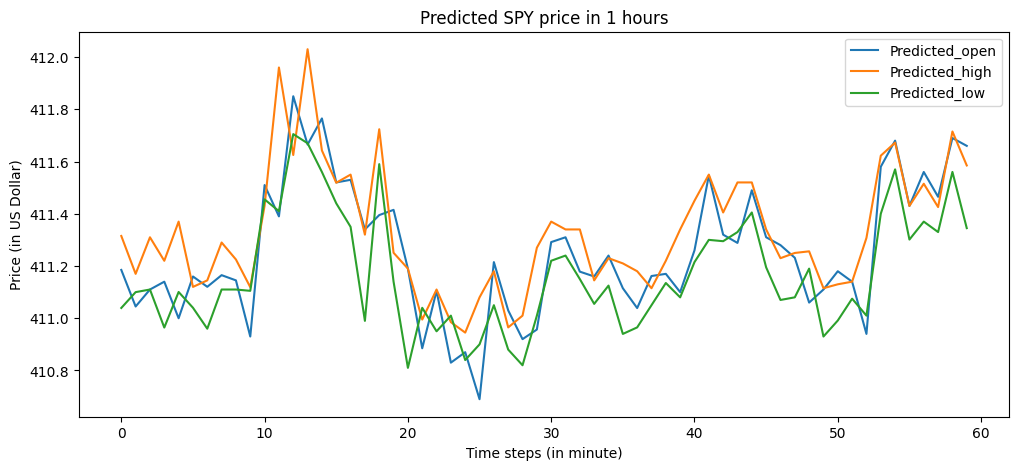

In [94]:
### Plot the predicted price
### Observe potential problems here: low > high for some predictions

plt.figure(figsize=(12,5))
pred_open = plt.plot(range(num_prediction), predicted_stock_data[:,0])
pred_high = plt.plot(range(num_prediction), predicted_stock_data[:,1])
pred_low = plt.plot(range(num_prediction), predicted_stock_data[:,2])
plt.title('Predicted SPY price in 1 hours')
plt.legend(('Predicted_open', 'Predicted_high', 'Predicted_low'))
plt.xlabel('Time steps (in minute)')
plt.ylabel('Price (in US Dollar)')

plt.show()

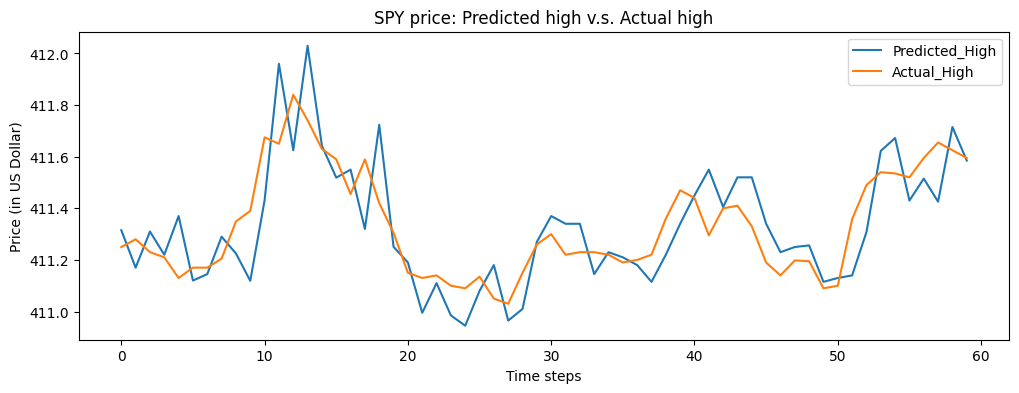

In [98]:
### Plot high price comparison
plt.figure(figsize=(12,4))
pred = plt.plot(range(num_prediction), predicted_stock_data[:, 1])
actual = plt.plot(range(num_prediction),np.flipud(data_whole[range(num_prediction),1]))
plt.title('SPY price: Predicted high v.s. Actual high')
plt.legend(('Predicted_High', 'Actual_High'))
plt.xlabel('Time steps')
plt.ylabel('Price (in US Dollar)')

plt.show()

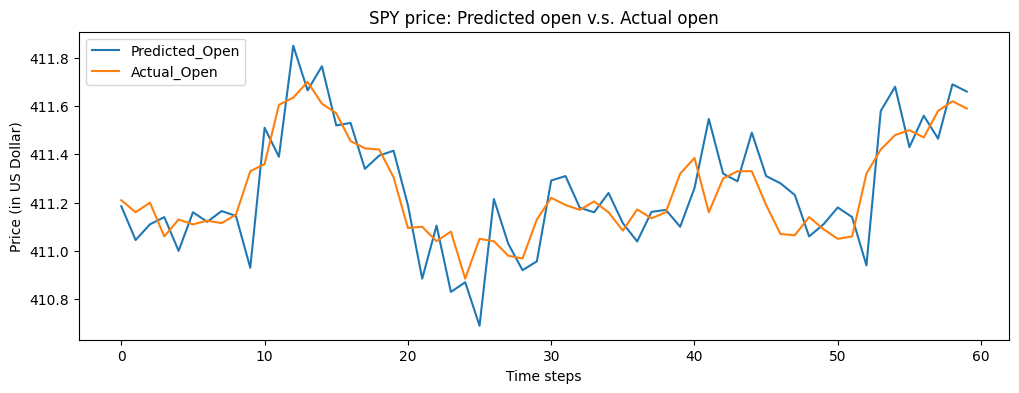

In [97]:
### Plot open price comparison
plt.figure(figsize=(12,4))
pred = plt.plot(range(num_prediction), predicted_stock_data[:, 0])
actual = plt.plot(range(num_prediction),np.flipud(data_whole[range(num_prediction),0]))
plt.title('SPY price: Predicted open v.s. Actual open')
plt.legend(('Predicted_Open', 'Actual_Open'))
plt.xlabel('Time steps')
plt.ylabel('Price (in US Dollar)')

plt.show()

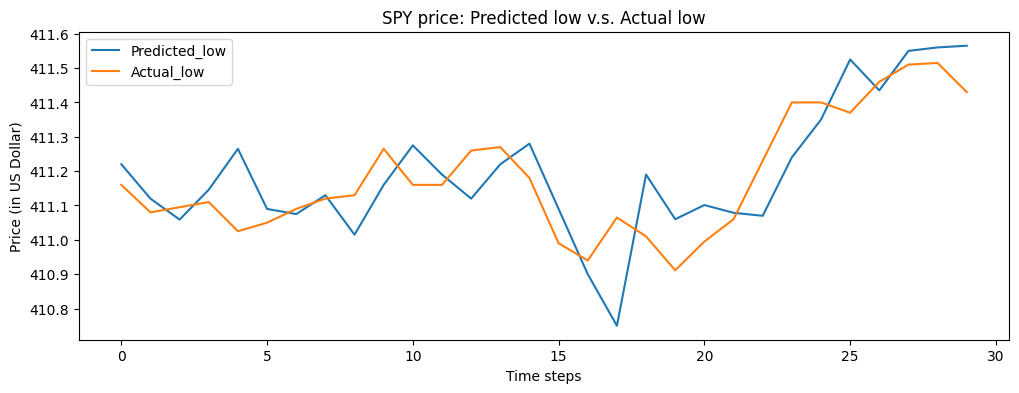

In [108]:
### Plot low price comparisons

plt.figure(figsize=(12,4))
pred = plt.plot(np.arange(0,30,1), predicted_stock_data[:, 2])
actual = plt.plot(range(num_prediction),np.flipud(data_whole[range(num_prediction),2]))
plt.title('SPY price: Predicted low v.s. Actual low')
plt.legend(('Predicted_low', 'Actual_low'))
plt.xlabel('Time steps')
plt.ylabel('Price (in US Dollar)')

plt.show()

In [15]:
# plt.figure(figsize=(20,9))

# # plt.plot(df_merged.time, df_merged['open'])
# # plt.plot(df_merged.time, df_merged['high'])
# # plt.plot(df_merged.time, df_merged['low'])
# # plt.plot(df_merged.time, df_merged['close'])
# plt.plot(dfhl.time, dfhl['open'])

# plt.xlabel("Date", fontsize=18)
# plt.ylabel("Price", fontsize=18)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.show()